<img src='https://i.imgur.com/PclbNN8.png'>


<h1><center>❄Alaska2❄ Competiton: EDA and Understanding</center></h1>

# 1. Competition Outline

<div class="alert alert-block alert-info">
Steganography is the method of hiding secret data in any image/audio/video. In a nutshell, the main motive of steganography is to hide the intended information within any image/audio/video that doesn’t appear to be secret just by looking at</div>

<img src='https://i.imgur.com/jo2sZgO.png' width=500>

## 1.1 Description

* **Current Methods** : Produce unreliable results, raising false alarms
* **Data** : images acquired with ~ 50 different cameras and processed in different fashions

## 1.2 Evaluation
* submissions are evaluated on the *weighted AUC*
* each region of the ROC curve is weighted according to these chosen parameters:
    * `tpr_thresholds = [0.0, 0.4, 1.0]`
    * `weights = [2, 1]`

<img src='https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F1951250%2Ff250ff6a4e04bac332fa14d539ed813e%2FKaggle.png?generation=1588207999884987&alt=media' width=400>

## 1.3 Sumbission file
For each Id (image) in the test set, you must provide a score that indicates *how likely this image contains hidden data*: the higher the score, the more it is assumed that image contains secret data.

## 1.4 Data
**Files**
* `Cover/` contains 75k unaltered images meant for use in training.
* `JMiPOD/` contains 75k examples of the JMiPOD algorithm applied to the cover images.
* `JUNIWARD/` contains 75k examples of the JUNIWARD algorithm applied to the cover images.
* `UERD/` contains 75k examples of the UERD algorithm applied to the cover images.
* `Test/` contains 5k test set images. These are the images for which you are predicting.
* `sample_submission.csv` contains an example submission in the correct format.

# 2. Libraries 📚

In [1]:
!pip install stegano                     # steganalysis library
!pip install -q efficientnet_pytorch     # Convolutional Neural Net from Google Research

     |████████████████████████████████| 300 kB 2.8 MB/s 
     |████████████████████████████████| 2.1 MB 12.5 MB/s 
ERROR: lime 0.2.0.0 has requirement pillow==5.4.1, but you'll have pillow 6.2.2 which is incompatible.
  Attempting uninstall: pillow
    Found existing installation: Pillow 5.4.1
    Uninstalling Pillow-5.4.1:
      Successfully uninstalled Pillow-5.4.1
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import stegano
from stegano import lsb

# System
import cv2
import os, os.path
from PIL import Image              # from RBG to YCbCr

# Basics
import pandas as pd
import numpy as np
from numpy import pi                # for DCT
from numpy import r_                # for DCT
import scipy                        # for cosine similarity
from scipy import fftpack           # for DCT
import random
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg    # to check images
%matplotlib inline
from tqdm.notebook import tqdm      # beautiful progression bar

# SKlearn
from sklearn.model_selection import KFold
from sklearn import metrics

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch import FloatTensor, LongTensor
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F

# Data Augmentation for Image Preprocessing
from albumentations import (ToFloat, Normalize, VerticalFlip, HorizontalFlip, Compose, Resize,
                            RandomBrightness, RandomContrast, HueSaturationValue, Blur, GaussNoise)
from albumentations.pytorch import ToTensorV2, ToTensor
from efficientnet_pytorch import EfficientNet
from torchvision.models import resnet34

import warnings
warnings.filterwarnings("ignore")

In [3]:
print(list(os.listdir("../input/v2-effnet-epoch-6-auc-08023")))

['4Class_epoch_9_val_loss_112.91_auc_0.7946_EffNetB0.pth', 'Epoch_7_ValLoss_58.146_AUC_0.799.pth', '10Class_epoch_14_val_loss_77.34_auc_0.78_EffNetB0.pth']


# 3. Example: Stegano Library

**Images encoded data**: Usually images have 3 channels (RGB), composed by pixels, which *describe* the image (the colors).
<img src='https://upload.wikimedia.org/wikipedia/en/thumb/9/9c/Steganography.png/465px-Steganography.png' width=400>

> [Stegano package documentation](https://buildmedia.readthedocs.org/media/pdf/stegano/latest/stegano.pdf) : this package hides the *hidden information* in the *least significant bits* of the image. These bits have the property of being very random (white noise), so they don't *fire* when some change is applied to them. 

Message encoded blue cats from Mars are coming to enslave us all be aware!!!!!!


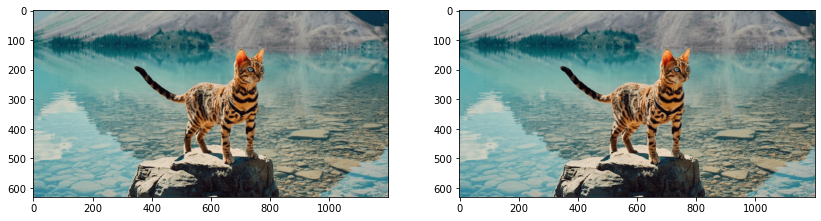

In [4]:
# Create a new image with secret message
msg_to_hide = "Message encoded blue cats from Mars are coming to enslave us all be aware!!!!!!"
secret = lsb.hide("../input/suki-image/capture27.png", 
                    msg_to_hide, 
                    auto_convert_rgb=True)
secret.save("./SukiSecret.png")

# Reveal the hidden message
print(lsb.reveal("./SukiSecret.png"))

# See the 2 images side by side (no apparent difference, but WE KNOW the text is there.)
f, ax = plt.subplots(1, 2, figsize=(14,5))
                           
original = mpimg.imread('../input/suki-image/capture27.png')
original_plot = ax[0].imshow(original)

altered = mpimg.imread('./SukiSecret.png')
altered_plot = ax[1].imshow(altered)

### Checking Similarity 🌜🌛
We can check how similar are the images by substracting one matrix from the other. 

Let's check the **similarity** of the abote 2 images, to see if there is any hidden information in the altered image:

In [5]:
# From image to array 
# (vectorize the matrix to be able to feed it to the cosine function)
original_vector = np.array(original).flatten()
altered_vector = np.array(altered).flatten()

print('Original shape:', original_vector.shape, '\n' +
      'Altered shape:', altered_vector.shape)


# Distance between the original image and itself (should be 0, because they are identical)
dist1 = np.sum(original_vector - original_vector)
print('Dist1:', dist1)

# Distance between the original image and altered image
dist2 = np.sum(original_vector - altered_vector)
print('Dist2:', dist2)

Original shape: (2268000,) 
Altered shape: (2268000,)
Dist1: 0.0
Dist2: -0.019607842


# 4. Alaska2 Images - EDA

## 4.1 Read in the data
There are 75k files in Cover, JMiPOD, JUNIWARD and UERD and 5k files in Test. We can't read the image arrays all at once, because the available RAM is not enough to perform this task.

In [6]:
# ---- STATICS ----
base_path = '../input/alaska2-image-steganalysis'

def read_images_path(dir_name='Cover', test = False):
    '''series_name: 0001.jpg, 0002.jpg etc.
    series_paths: is the complete path to a certain image.'''
    
    # Get name of the files
    series_name = pd.Series(os.listdir(base_path + '/' + dir_name))
    if test:
        series_name = pd.Series(os.listdir(base_path + '/' + 'Test'))
    
    # Create the entire path
    series_paths = pd.Series(base_path + '/' + dir_name + '/' + series_name)
    
    return series_paths

In [7]:
# Read in the data
cover_paths = read_images_path('Cover', False)
jmipod_paths = read_images_path('JMiPOD', False)
juniward_paths = read_images_path('JUNIWARD', False)
uerd_paths = read_images_path('UERD', False)
test_paths = read_images_path('Test', True)

### Show some Images

In [8]:
def show15(title = "Default"):
    '''Shows n amount of images in the data'''
    plt.figure(figsize=(16,9))
    plt.suptitle(title, fontsize = 16)
    
    for k, path in enumerate(cover_paths[:15]):
        cover = mpimg.imread(path)
        
        plt.subplot(3, 5, k+1)
        plt.imshow(cover)
        plt.axis('off')

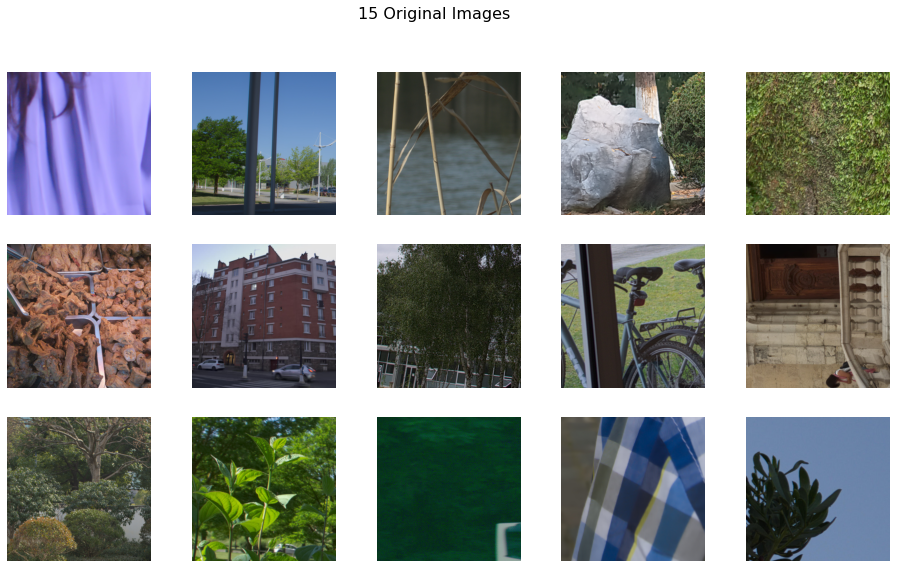

In [9]:
show15(title = "15 Original Images")

### Images shape, size, data type
* all images are 512 x 512 x 3
* all images are of size 786,432 
* all images are uint8 type

In [10]:
image_sample = mpimg.imread(cover_paths[0])

print('Image sample shape:', image_sample.shape)
print('Image sample size:', image_sample.size)
print('Image sample data type:', image_sample.dtype)

Image sample shape: (512, 512, 3)
Image sample size: 786432
Image sample data type: uint8


## 4.2 Algorithms
There are 3 main different algorithms applied to the original image and used to encode information into it:
* JMiPOD 
* JUNIWARD
* UERD

> All images have the corresponding encoding at the same name.

In [11]:
def show_images_alg(n = 3, title="Default"):
    '''Returns a plot of the original Image and Encoded ones.
    n: number of images to display'''
    
    f, ax = plt.subplots(n, 4, figsize=(16, 7))
    plt.suptitle(title, fontsize = 16)
    

    for index in range(n):
        cover = mpimg.imread(cover_paths[index])
        ipod = mpimg.imread(jmipod_paths[index])
        juni = mpimg.imread(juniward_paths[index])
        uerd = mpimg.imread(uerd_paths[index])

        # Plot
        ax[index, 0].imshow(cover)
        ax[index, 1].imshow(ipod)
        ax[index, 2].imshow(juni)
        ax[index, 3].imshow(uerd)
        
        # Add titles
        if index == 0:
            ax[index, 0].set_title('Original', fontsize=12)
            ax[index, 1].set_title('IPod', fontsize=12)
            ax[index, 2].set_title('Juni', fontsize=12)
            ax[index, 3].set_title('Uerd', fontsize=12)

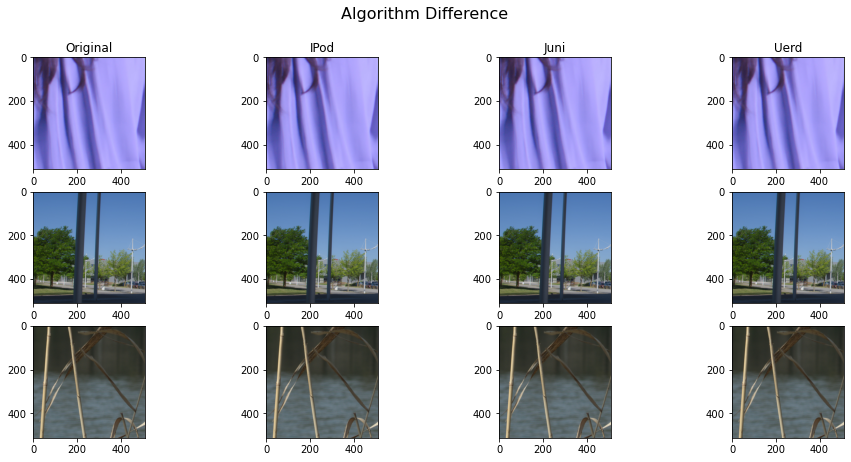

In [12]:
show_images_alg(n = 3, title = "Algorithm Difference")

# 5. JPEG Images: Where is the information?

* [Inspo and Understanding here](https://www.kaggle.com/tanulsingh077/steganalysis-complete-understanding-and-model)
* [From Image to JPEG here](https://www.graphicsmill.com/docs/gm5/UnderstandingofJPEGEncodingParameters.htm)

<img src='https://i.imgur.com/c54ht2c.png' width=600>


### Hiding information
1. In the YCbCr channels: this is an old approach and can be easily found (as we saw in the Suki example)
2. DCT Coefficients of the YCbCr channels: the payload (secret information) is randomly distributed

> Either YCbCr or DCT Coeff can be used as **inputs** to the neural net

## 5.1 Visualize YCbCr Channels:

In [13]:
def show_ycbcr_images(n = 3, title = "Default"):
    '''Shows n images as: original RGB, YCbCr and Y, Cb, Cr channels split'''
    
    # 4: original image, YCbCr image, Y, Cb, Cr (separate chanels)
    fig, ax = plt.subplots(n, 5, figsize=(16, 7))
    plt.suptitle(title, fontsize = 16)

    for index, path in enumerate(cover_paths[:n]):
        # Read in the original image and convert
        original_image = Image.open(path)
        ycbcr_image = original_image.convert('YCbCr')
        (y, cb, cr) = ycbcr_image.split()

        # Plot
        ax[index, 0].imshow(original_image)
        ax[index, 1].imshow(ycbcr_image)
        ax[index, 2].imshow(y)
        ax[index, 3].imshow(cb)
        ax[index, 4].imshow(cr)

        # Add Title
        if index==0:
            ax[index, 0].set_title('Original', fontsize=12)
            ax[index, 1].set_title('YCbCr', fontsize=12)
            ax[index, 2].set_title('Y', fontsize=12)
            ax[index, 3].set_title('Cb', fontsize=12)
            ax[index, 4].set_title('Cr', fontsize=12)

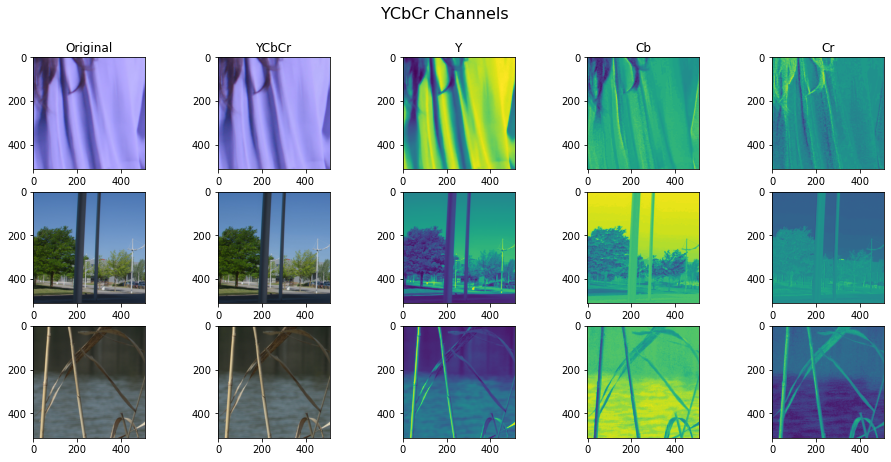

In [14]:
show_ycbcr_images(n = 3, title = "YCbCr Channels")

## 5.2 Visualize DCT Coefficients:

### Discrete Cosine Transform Example
* [finite sequence of data points in terms of a sum of cosine functions oscillating at different frequencies](https://en.wikipedia.org/wiki/Discrete_cosine_transform)
* transformation tenchnique for data compression 
* uses *cosine* rather than *sine* (faster computation)

> [The following code is completely taken from this page: JPEG DCT Demo](https://inst.eecs.berkeley.edu/~ee123/sp16/Sections/JPEG_DCT_Demo.html#Display-all-DCT-blocks)

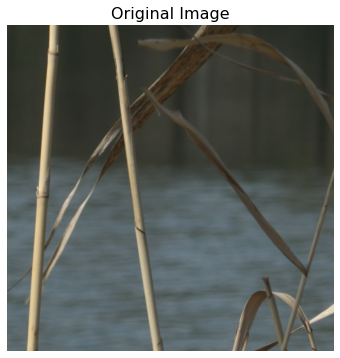

In [15]:
# Read in an Image Example
image = mpimg.imread(cover_paths[2])

plt.figure(figsize = (6, 6))
plt.imshow(image)
plt.title('Original Image', fontsize=16)
plt.axis('off');

#### Create DCT Function:

In [16]:
# Define 2D DCT
def dct2(a):
    # Return the Discrete Cosine Transform of arbitrary type sequence x.
    return fftpack.dct(fftpack.dct( a, axis=0, norm='ortho' ), axis=1, norm='ortho')

# Perform a blockwise DCT
imsize = image.shape
dct = np.zeros(imsize)

# Do 8x8 DCT on image (in-place)
for i in r_[:imsize[0]:8]:
    for j in r_[:imsize[1]:8]:
        dct[i:(i+8),j:(j+8)] = dct2( image[i:(i+8),j:(j+8)] )

### Look at an 8x8 block: original vs DCT coeff

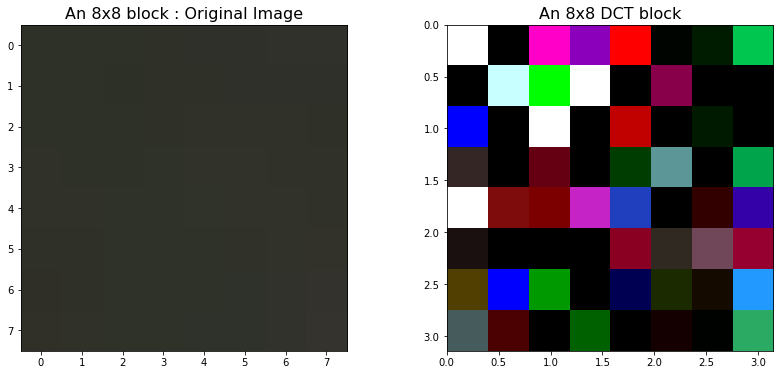

In [17]:
# ---- STATICS ----
pos = 128   # can be changed

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Display original
ax1.imshow(image[pos:pos+8,pos:pos+8],cmap='gray')
ax1.set_title("An 8x8 block : Original Image", fontsize=16)

# Display the dct of that block
ax2.imshow(dct[pos:pos+8,pos:pos+8],cmap='gray',vmax= np.max(dct)*0.01,vmin = 0, extent=[0,pi,pi,0])
ax2.set_title("An 8x8 DCT block", fontsize = 16);

### Display ALL DCT blocks against the original image

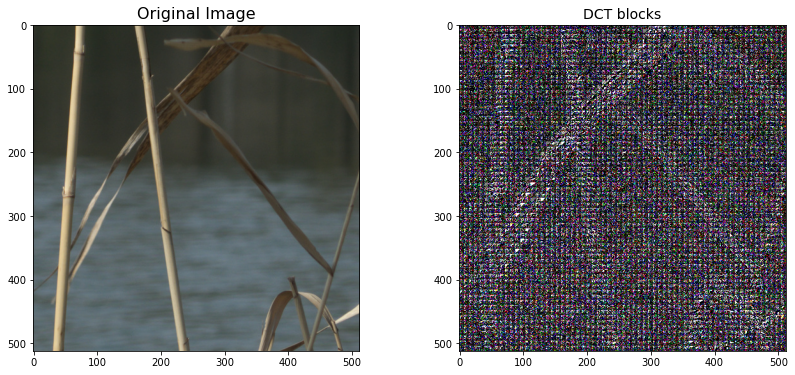

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Original image
ax1.imshow(image);
ax1.set_title("Original Image", fontsize = 16);

# DCT Blocks
ax2.imshow(dct,cmap='gray',vmax = np.max(dct)*0.01,vmin = 0)
ax2.set_title("DCT blocks", fontsize = 14);

### Bonus: Threshold DCT Coefficients
> Keeping only a percentage of the coefficients

Keeping only 7.305% of the DCT coefficients


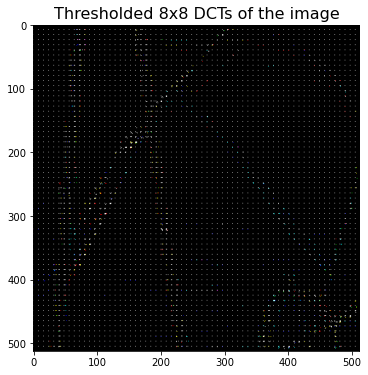

In [19]:
# Threshold
thresh = 0.02
dct_thresh = dct * (abs(dct) > (thresh*np.max(dct)))


plt.figure(figsize=(14, 6))
plt.imshow(dct_thresh, cmap='gray', vmax = np.max(dct)*0.01, vmin = 0)
plt.title("Thresholded 8x8 DCTs of the image", fontsize = 16)

percent_nonzeros = np.sum( dct_thresh != 0.0 ) / (imsize[0]*imsize[1]*1.0)
print("Keeping only {}% of the DCT coefficients".format(round(percent_nonzeros*100.0, 3)))

<h1><center>❄Model❄: Multiclass PyTorch with EffNet</center></h1>

<div class="alert alert-block alert-warning">
<p>Note: Inspiration for this notebook is from <a href='https://www.kaggle.com/meaninglesslives/alaska2-cnn-multiclass-classifier?scriptVersionId=33731720'>Alaska2 CNN Multiclass Classifier</a> </p>
</div>

# 1. Preparing the data 🔎

## 1.1 Set the seeds🌱

In [20]:
def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now:', device)

Device available now: cuda


## 1.2 Data📁

* `.extend()`: Extend list by appending elements from the iterable.

> The code below does the following:
<img src ='https://i.imgur.com/zLK7iRb.png' width=500>

In [21]:
# ----- STATICS -----
sample_size = 256
num_classes = 4
# -------------------

# Read in Data

# --- 10 classes ---
# train_df = pd.read_csv('../input/alaska2trainvalsplit/alaska2_train_df.csv', 
#                        header=0, names=['Path', 'Label'], dtype = {'Label':np.int32})
# valid_df = pd.read_csv('../input/alaska2trainvalsplit/alaska2_val_df.csv', 
#                        header=0, names=['Path', 'Label'], dtype = {'Label':np.int32})

# --- 4 classes ---
train_df = pd.read_csv('../input/alaska2-trainvalid-4-class-csv/alaska2_train_data_4classes.csv', 
                       header=0, names=['Path', 'Label'], dtype = {'Label':np.int32})
valid_df = pd.read_csv('../input/alaska2-trainvalid-4-class-csv/alaska2_valid_data_4classes.csv', 
                       header=0, names=['Path', 'Label'], dtype = {'Label':np.int32})

# Sample out Data
def sample_data(dataframe, sample_size, num_classes, train=True):
    '''Sample same number of images for each label.'''
    if train:
        size = int(0.75 * sample_size)
    else:
        size = int(0.25 * sample_size)
        
    # Number of images in class
    no = int(np.floor(size/num_classes))
    labels = [i for i in range(num_classes)]
    new_data = pd.DataFrame()
    
    # For each label
    for label in labels:
        # Sample out data
        data = dataframe[dataframe['Label'] == label].sample(no, random_state=123)
        new_data = pd.concat([new_data, data], axis=0)
        
    return new_data

In [22]:
# Sample out data
train_df = sample_data(train_df, num_classes=num_classes, 
                       sample_size=sample_size, train=True).reset_index(drop=True)
valid_df = sample_data(valid_df, num_classes=num_classes, 
                       sample_size=sample_size, train=False).reset_index(drop=True)

#### Check if the result is OK

Train Data Size: 192 
Valid Data Size: 64 
---------------------- 
Total: 256


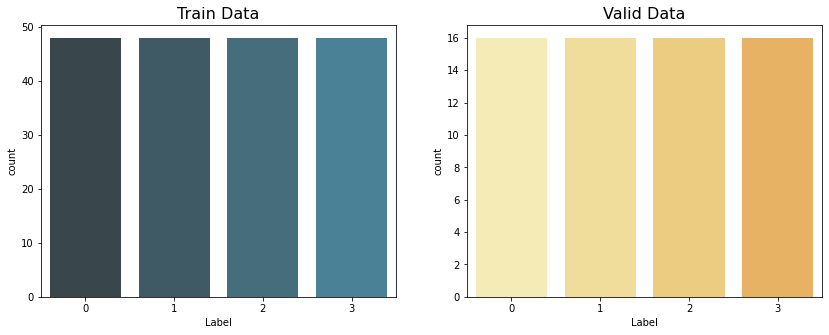

In [23]:
print('Train Data Size:', len(train_df), '\n' +
      'Valid Data Size:', len(valid_df), '\n' +
      '----------------------', '\n' +
      'Total:', len(train_df) + len(valid_df))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 5))

sns.countplot(x = train_df['Label'], ax = ax1, palette = sns.color_palette("GnBu_d", 10))
sns.countplot(x = valid_df['Label'], ax = ax2, palette = sns.color_palette("YlOrRd", 10))

ax1.set_title('Train Data', fontsize=16)
ax2.set_title('Valid Data', fontsize=16);

# 2. PyTorch Dataset 🛠

### Dataset Class
[Link here with example and more explanations](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

`torch.utils.data.Dataset` is an abstract class representing a dataset. Your custom dataset should inherit `Dataset` and override the following methods:
* `__len__` so that len(dataset) returns the size of the dataset.
* `__getitem__` to support the indexing such that dataset[i] can be used to get i'th sample

> Note1: Some images are 512x512, so we'll resize first to have everything the same shape

> Note2: [This discussion](https://www.kaggle.com/c/alaska2-image-steganalysis/discussion/155392) explains why is better NOT to resize the images further (information within image is scarce, you don't want to make it even more scarce).

<img src='https://i.imgur.com/Q69gqzt.png' width=400>

In [24]:
class AlaskaDataset(Dataset):
    '''Alaska2 Dataset.
    If data is test or eval, it skips the transformations applied to training part.'''
            
    def __init__(self, dataframe, is_test, is_val, vertical_flip=0.5, horizontal_flip=0.5):
        self.dataframe, self.is_test, self.is_val = dataframe, is_test, is_val
        self.vertical_flip, self.horizontal_flip = vertical_flip, horizontal_flip
        # Flag to mark Testing and Evaluation Datasets
        flag = is_test or is_val
        
        # If data is NOT Train
        if flag:
            self.transform = Compose([Resize(512, 512), 
                                      Normalize(),
                                      ToFloat(max_value=255),
                                      ToTensor()])
        else:
            # Compose transforms and handle all transformations regarding bounding boxes
            self.transform = Compose([Resize(512, 512), 
                                      VerticalFlip(p = vertical_flip),
                                      HorizontalFlip(p = horizontal_flip),
                                      Normalize(),
                                      ToFloat(max_value=255),
                                      # Convert image and mask to torch.Tensor
                                      ToTensor()])        
        
    
    # So len(data) returns the size of dataset
    def __len__(self):
        return len(self.dataframe)
    
    # Very important function for Data Loader
    def __getitem__(self, index):
        
        if self.is_test: 
            path = self.dataframe.loc[index][0]
        else:
            path, label = self.dataframe.loc[index]
        
        # ::-1 to not overload memory
        image = cv2.imread(path)[:, :, ::-1]
        image = self.transform(image=image)
        image = image['image']
        
        if self.is_test:
            return image
        else:
            return image, label

# 3. Network 🛠

## 3.1 Efficient Net

<div class="alert alert-block alert-info">
<img src='https://i.imgur.com/H6AnLaj.png' width='90' align='left'></img>
<p><a href='https://www.youtube.com/watch?v=3svIm5UC94I'>EfficientNet Explained!</a></p>
<p>Henry AI Labs</p>
</div>

**What is Efficient Net?**
* Dedeloped by Google AI Research: rethinks the way we SCALE CNNs up
* Scaling up can be done in many ways:
    * Width: adding more feature maps
    * Depth: adding more layers
    * Resolution: increasing the resolution of the input image
    
<img src='https://i.imgur.com/JN5H0ae.png' width=700>

> There are many EfficientNets: from B0 to B7, all with different performances.
<img src='https://i.imgur.com/VMTiu5R.png' width=300>

In [25]:
class EfficientNetwork(nn.Module):
    def __init__(self, output_size, b1=False, b2=False):
        super().__init__()
        self.b1, self.b2 = b1, b2
        
        # Define Feature part
        if b1:
            self.features = EfficientNet.from_pretrained('efficientnet-b1')
        elif b2:
            self.features = EfficientNet.from_pretrained('efficientnet-b2')
        else:
            self.features = EfficientNet.from_pretrained('efficientnet-b0')
        
        # Define Classification part
        if b1:
            self.classification = nn.Linear(1280, output_size)
        elif b2:
            self.classification = nn.Linear(1408, output_size)
        else:
            self.classification = nn.Linear(1280, output_size)
        
        
    def forward(self, image, prints=False):
        if prints: print('Input Image shape:', image.shape)
        
        image = self.features.extract_features(image)
        if prints: print('Features Image shape:', image.shape)
            
        if self.b1:
            image = F.avg_pool2d(image, image.size()[2:]).reshape(-1, 1280)
        elif self.b2:
            image = F.avg_pool2d(image, image.size()[2:]).reshape(-1, 1408)
        else:
            image = F.avg_pool2d(image, image.size()[2:]).reshape(-1, 1280)
        if prints: print('Image Reshaped shape:', image.shape)
        
        out = self.classification(image)
        if prints: print('Out shape:', out.shape)
        
        return out

### How is the Model working?

> A schema of the example below:
<img src='https://i.imgur.com/FIHb9Ko.png' width=500>

In [26]:
# Create an example model (B2)
model_example = EfficientNetwork(output_size=num_classes, b1=False, b2=True)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/checkpoints/efficientnet-b2-8bb594d6.pth



Loaded pretrained weights for efficientnet-b2


In [27]:
# Data object and Loader
example_data = AlaskaDataset(train_df, is_test=False, is_val=False)
example_loader = torch.utils.data.DataLoader(example_data, batch_size = 1, shuffle=True)

# Get a sample
for image, labels in example_loader:
    images_example = image
    labels_example = torch.tensor(labels, dtype=torch.long)
    break
print('Images shape:', images_example.shape)
print('Labels:', labels, '\n')

# Outputs
out = model_example(images_example, prints=True)

# Criterion example
criterion_example = nn.CrossEntropyLoss()
loss = criterion_example(out, labels_example)
print('Loss:', loss.item())

Images shape: torch.Size([1, 3, 512, 512])
Labels: tensor([0], dtype=torch.int32) 

Input Image shape: torch.Size([1, 3, 512, 512])
Features Image shape: torch.Size([1, 1408, 16, 16])
Image Reshaped shape: torch.Size([1, 1408])
Out shape: torch.Size([1, 4])
Loss: 1.377244234085083


## 3.2 ResNet34

* Deep architecture for CNNs that solve vanishing gradient problem
* Weights can be applied to other Classification problems (like we have here :) )

> Note: [Full blog post here](https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8)
<img src='https://miro.medium.com/max/1400/1*Y-u7dH4WC-dXyn9jOG4w0w.png' width=500>

In [28]:
class ResNet34Network(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        
        # Define Feature part
        self.features = resnet34(pretrained=True)
        
        # Define Classification part
        self.classification = nn.Linear(1000, output_size)
        
        
    def forward(self, image, prints=False):
        if prints: print('Input Image shape:', image.shape)
        
        image = self.features(image)
        if prints: print('Features Image shape:', image.shape)
        
        out = self.classification(image)
        if prints: print('Out shape:', out.shape)
        
        return out

### How is the Model working?
<img src='https://i.imgur.com/Xc0kARY.png' width=500>

In [29]:
# Create an example model
model_example = ResNet34Network(output_size=num_classes)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [30]:
# Data object and Loader
example_data = AlaskaDataset(train_df, is_test=False, is_val=False)
example_loader = torch.utils.data.DataLoader(example_data, batch_size = 1, shuffle=True)

# Get a sample
for image, labels in example_loader:
    images_example = image
    labels_example = torch.tensor(labels, dtype=torch.long)
    break
print('Images shape:', images_example.shape)
print('Labels:', labels, '\n')

# Outputs
out = model_example(images_example, prints=True)

# Criterion example
criterion_example = nn.CrossEntropyLoss()
loss = criterion_example(out, labels_example)
print('Loss:', loss.item())

Images shape: torch.Size([1, 3, 512, 512])
Labels: tensor([2], dtype=torch.int32) 

Input Image shape: torch.Size([1, 3, 512, 512])
Features Image shape: torch.Size([1, 1000])
Out shape: torch.Size([1, 4])
Loss: 0.8920363783836365


# 4. Data Prep 💽

In [31]:
# ----- STATICS -----
vertical_flip = 0.5
horizontal_flip = 0.5
# -------------------

In [32]:
# Data Objects
train_data = AlaskaDataset(train_df, is_test=False, is_val=False, 
                           vertical_flip=vertical_flip, horizontal_flip=horizontal_flip)
valid_data = AlaskaDataset(valid_df, is_test=False, is_val=True, 
                           vertical_flip=vertical_flip, horizontal_flip=horizontal_flip)

# 5. Train and Weighted AUC Functions 💾

> Note: Function from  notebook [Weighted AUC Metric (Updated)](https://www.kaggle.com/anokas/weighted-auc-metric-updated)

* Optimizer:
    * The original `Adam` algorithm was proposed in `Adam: A Method for Stochastic Optimization`
    * The `AdamW` variant was proposed in `Decoupled Weight Decay Regularization`
    
<div class="alert alert-block alert-success">
<p>Note to self: Try different Criterions and Optimizers.</p>
</div>

In [33]:
def alaska_weighted_auc(y_true, y_valid):
    tpr_thresholds = [0.0, 0.4, 1.0]
    weights = [2, 1]
    
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_valid, pos_label=1)
    
    # Size of subsets
    areas = np.array(tpr_thresholds[1:]) - np.array(tpr_thresholds[:-1])
    
    # The total area is normalized by the sum of weights such that the final weighted AUC is between 0 and 1.
    normalization = np.dot(areas, weights)
    
    competition_metric = 0
    for idx, weight in enumerate(weights):
        y_min = tpr_thresholds[idx]
        y_max = tpr_thresholds[idx + 1]
        mask = (y_min < tpr) & (tpr < y_max)

        x_padding = np.linspace(fpr[mask][-1], 1, 100)

        x = np.concatenate([fpr[mask], x_padding])
        y = np.concatenate([tpr[mask], [y_max] * len(x_padding)])
        # Normalize such that curve starts at y = 0
        y = y - y_min 
        score = metrics.auc(x, y)
        submetric = score * weight
        best_subscore = (y_max - y_min) * weight
        competition_metric += submetric
        
    return competition_metric / normalization

> Method of computing New Predictions is from here: [Alaska2 CNN Multiclass Classifier](https://www.kaggle.com/meaninglesslives/alaska2-cnn-multiclass-classifier). Below you ca also find a helpful schema of the code below:
<img src='https://i.imgur.com/MEV7VQh.png' width = 600>

In [34]:
def train(model, epochs, batch_size, num_workers, learning_rate, weight_decay, 
          version = 'vx', plot_loss=False):
    # Create file to save logs
    f = open(f"logs_{version}.txt", "w+")
    
    # Best AUC value
    best_auc = None    
    
    # Data Loaders
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers,
                                              drop_last=True, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers,
                                              drop_last=True, shuffle=True)

    # Criterion
    criterion = torch.nn.CrossEntropyLoss()
    # Optimizer
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    # Scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='max',
                                                           patience=1, verbose=True, factor=0.4)


    train_losses = []
    evaluation_losses = []

    for epoch in range(epochs):

        # Sets the model in training mode
        model.train()

        train_loss = 0

        for images, labels in train_loader:
            # Need to access the images
            images = images.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.long)

            # Clear gradients
            optimizer.zero_grad()

            # Make prediction
            out = model(images)

            # Compute loss and Backpropagate
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Compute average epoch loss
        epoch_loss_train = train_loss / batch_size
        train_losses.append(epoch_loss_train)


        # ===== Evaluate =====
        model.eval()

        evaluation_loss = 0
        actuals, predictions = [], []

        # To disable gradients
        with torch.no_grad():
            for images, labels in valid_loader:
                images = images.to(device, dtype=torch.float)
                labels = labels.to(device, dtype=torch.long)

                # Prediction
                out = model(images)
                loss = criterion(out, labels)
                actuals.extend(labels.cpu().numpy().astype(int))
                predictions.extend(F.softmax(out, 1).cpu().numpy())

                evaluation_loss += loss.item()

        # Compute epoch loss
        epoch_loss_eval = evaluation_loss/batch_size
        evaluation_losses.append(epoch_loss_eval)

        # Prepare predictions and actuals
        predictions = np.array(predictions)
        # Choose label (array)
        predicted_labels = predictions.argmax(1)

        # ----- Accuracy -----
        accuracy = (predicted_labels == actuals).mean()

        # Compute AUC
        new_preds = np.zeros(len(predictions))
        temp = predictions[predicted_labels != 0, 1:]

        new_preds[predicted_labels != 0] = temp.sum(1)
        new_preds[predicted_labels == 0] = 1 - predictions[predicted_labels == 0, 0]
        actuals = np.array(actuals)
        actuals[actuals != 0] = 1

        auc_score = alaska_weighted_auc(actuals, new_preds)


        with open(f"logs_{version}.txt", 'a+') as f:
            print('Epoch: {}/{} | Train Loss: {:.3f} | Eval Loss: {:.3f} | AUC: {:3f} | Acc: {:3f}'.\
                     format(epoch+1, epochs, epoch_loss_train, epoch_loss_eval, auc_score, accuracy), file=f)
        
        print('Epoch: {}/{} | Train Loss: {:.3f} | Eval Loss: {:.3f} | AUC: {:3f} | Acc: {:3f}'.\
              format(epoch+1, epochs, epoch_loss_train, epoch_loss_eval, auc_score, accuracy))

        # Update AUC
        # If AUC is improving, then we also save model
        if best_auc == None:
            best_auc = auc_score
            torch.save(model.state_dict(),
                       f"Epoch_{epoch+1}_ValLoss_{epoch_loss_eval:.3f}_AUC_{auc_score:.3f}.pth")
            continue
            
        if auc_score > best_auc:
            best_auc = auc_score
            torch.save(model.state_dict(),
                       f"Epoch_{epoch+1}_ValLoss_{epoch_loss_eval:.3f}_AUC_{auc_score:.3f}.pth")
        
        # Update scheduler (for learning_rate)
        scheduler.step(auc_score)
        
    # Plots the loss of Train and Valid
    if plot_loss:
        plt.figure(figsize=(14,5))
        plt.plot(train_losses, c='#fdc975ff', lw = 3)
        plt.plot(evaluation_losses, c='#29896bff', lw = 3)
        plt.legend(['Train Loss', 'Evaluation Loss'])
        plt.title('Losses over Epochs');

# 6. Training...💻✔

In [35]:
# ----- STATICS -----
version = 'v8'
epochs = 3
batch_size = 32
num_workers = 8
learning_rate = 0.001
weight_decay = 0.00001
plot_loss = False
# -------------------

In [36]:
# # Efficient Net B0
# eff_net0 = EfficientNetwork(output_size = num_classes, b1=False, b2=False).to(device)

# # Load any pretrained model
# eff_net0.load_state_dict(torch.load('../input/v2-effnet-epoch-6-auc-08023/10Class_epoch_14_val_loss_77.34_auc_0.78_EffNetB0.pth'))

# # Uncomment and train the model
# train(model=eff_net0, epochs=epochs, batch_size=batch_size, num_workers=num_workers, 
#       learning_rate=learning_rate, weight_decay=weight_decay, plot_loss=plot_loss)

In [37]:
# Efficient Net B2
eff_net2 = EfficientNetwork(output_size = num_classes, b1=False, b2=True).to(device)

# # Add previous trained model:
# eff_net2.load_state_dict(torch.load('../input/v2-effnet-epoch-6-auc-08023/Epoch_7_ValLoss_58.146_AUC_0.799.pth'))

# Uncomment and train the model
# train(model=eff_net2, epochs=epochs, batch_size=batch_size, num_workers=num_workers, 
#       learning_rate=learning_rate, weight_decay=weight_decay, plot_loss=plot_loss)

Loaded pretrained weights for efficientnet-b2


In [38]:
# # ResNet34
# eff_net34 = ResNet34Network(output_size = num_classes).to(device)

# # Uncomment and train the model
# train(model=eff_net34, epochs=epochs, batch_size=batch_size, num_workers=num_workers, 
#       learning_rate=learning_rate, weight_decay=weight_decay, plot_loss=plot_loss)

# 7. Inference 📈

## 7.1 Data

In [39]:
# Extract a sample of paths
directory = '../input/alaska2-image-steganalysis/'
name = pd.Series(sorted(os.listdir(directory + 'Test/')))
path = pd.Series(directory + 'Test/' + name)

# Create dataframe
test_df = pd.DataFrame(data=path, columns=['Path'])

# Dataset
test_data = AlaskaDataset(test_df, is_test=True, is_val=False,
                          vertical_flip=vertical_flip, horizontal_flip=horizontal_flip)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle=False)

## 7.2 Predict

In [40]:
# list(os.listdir('../working/Epoch_17_ValLoss_36.195_AUC_0.794.pth'))

# Import model if necessary:
# Load any pretrained model
# eff_net2.load_state_dict(torch.load('../working/Epoch_17_ValLoss_36.195_AUC_0.794.pth'))

In [41]:
# Evaluation Mode
eff_net2.eval()

predictions = []

with torch.no_grad():
    for k, images in enumerate(test_loader):
        images = images.to(device)
        out0 = eff_net2(images)
        
        # Flip vertical
        images_vertical = images.flip(2)
        out1 = eff_net2(images_vertical)
        
        # Flip again original
        images_flip = images.flip(3)
        out2 = eff_net2(images_flip)
        
        # 50% results from flip + 50% result from normal
        outputs = (0.25*out1 + 0.25*out2)
        outputs = (outputs + 0.5*out0)

        predictions.extend(F.softmax(outputs, 1).cpu().numpy())

In [42]:
# Making the predictions the same manner as in Train Function
predictions = np.array(predictions)
predicted_labels = predictions.argmax(1)
new_preds = np.zeros(len(predictions))
temp = predictions[predicted_labels != 0, 1:]
new_preds[predicted_labels != 0] = temp.sum(1)
new_preds[predicted_labels == 0] = 1 - predictions[predicted_labels == 0, 0]

### Submission File

> Note: The submission will actually deliver only if you train on more datapoints (this is just a very small sample so the notebook runs fast :) )

In [43]:
ss = pd.read_csv('../input/alaska2-image-steganalysis/sample_submission.csv')
ss['Label'] = new_preds

ss.to_csv(f'submission_{version}.csv', index=False)

<div class="alert alert-block alert-success">
<p>EffNet B0 (10 class): 30,000 sample_size | 19 epochs | 16 batch_size | <strong>LB Score is 0.822.</strong></p>
<p>EffNet B2 (10 class): 70,000 sample_size | 15 epochs | 16 batch_size | <strong>LB Score is 0.805.</strong></p>
<p>Working to make it better.</p>
</div>

# To Continue...

<div class="alert alert-block alert-warning"> 
<p>If you liked this, upvote!</p>
<p>Cheers!</p>
</div>

# References

* [Definition of Steganalysis (Wiki)](https://en.wikipedia.org/wiki/Steganalysis)
* [Definition of Steganography (Wiki)](https://en.wikipedia.org/wiki/Steganography)
* [Steganalysis: Complete Understanding and models](https://www.kaggle.com/tanulsingh077/steganalysis-complete-understanding-and-model)
* [Stegano Documentation](https://buildmedia.readthedocs.org/media/pdf/stegano/latest/stegano.pdf)
* [Understanding JPEG Encoding](https://www.graphicsmill.com/docs/gm5/UnderstandingofJPEGEncodingParameters.htm)
* [Discrete Cosine Transform](https://en.wikipedia.org/wiki/Discrete_cosine_transform)
* [JPEG DCT Demo](https://inst.eecs.berkeley.edu/~ee123/sp16/Sections/JPEG_DCT_Demo.html#Display-all-DCT-blocks)
* [ALASKA2 Steganalysis: EfficientNet-B7 PyTorch](https://www.kaggle.com/tarunpaparaju/alaska2-steganalysis-efficientnet-b3-pytorch)
* [Pytorch.utils.data documentation](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)
* [Efficient Net Explained](https://www.youtube.com/watch?v=3svIm5UC94I)